In [1]:

import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

In [3]:


# Defining paths and parameters
DATASET_PATH = r"E:\dataset\la-2019\audio-deepfake-detection-main\dataset"
NUM_CLASSES = 2  # Number of classes (fake and real)
SAMPLE_RATE = 16000  # Sample rate of audio files
DURATION = 5  # Duration of audio clips in seconds
N_MELS = 128  # Number of Mel frequency bins


In [4]:


# Initialize empty lists for data and labels
X = []
y = []

# Max time steps for consistency in Mel spectrogram size
max_time_steps = 109  # Define the maximum time steps for thee model
 # CNN needs fixed (height, width, channels). Different audio lengths → different spectrogram widths; we pad/trim to max_time_steps

# Iterating through each file in the dataset directory
for file_name in os.listdir(DATASET_PATH):
    if file_name.endswith(".flac"):  # Only processing audio files
        file_path = os.path.join(DATASET_PATH, file_name)

        # Loading audio file using librosa
        audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        
        # Extracting Mel spectrogram using librosa
        mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
        mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # Ensure all spectrograms have the same width (time steps)
        if mel_spectrogram.shape[1] < max_time_steps:
            mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, max_time_steps - mel_spectrogram.shape[1])), mode='constant')
        else:
            mel_spectrogram = mel_spectrogram[:, :max_time_steps]

        # Append the spectrogram to X
        X.append(mel_spectrogram)

        # Extract the label from the filename (fake = 0, real = 1)
        if "fake" in file_name:
            label = 0
        elif "real" in file_name:
            label = 1
        else:
            print(f"Unknown label for file: {file_name}")
            continue
        
        # Append the label to y
        y.append(label)

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

c:\Users\pasin\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=192
  warnings.warn(
c:\Users\pasin\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=128
  warnings.warn(
c:\Users\pasin\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=279
  warnings.warn(
c:\Users\pasin\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=384
  warnings.warn(
c:\Users\pasin\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=140
  warnings.warn(


In [5]:

X,y

(array([[[-67.619705, -65.01982 , -62.9589  , ...,   0.      ,
            0.      ,   0.      ],
         [-75.57022 , -71.72113 , -66.72965 , ...,   0.      ,
            0.      ,   0.      ],
         [-79.0564  , -78.19148 , -76.20949 , ...,   0.      ,
            0.      ,   0.      ],
         ...,
         [-80.      , -77.367096, -47.808624, ...,   0.      ,
            0.      ,   0.      ],
         [-80.      , -80.      , -51.49805 , ...,   0.      ,
            0.      ,   0.      ],
         [-80.      , -80.      , -68.149254, ...,   0.      ,
            0.      ,   0.      ]],
 
        [[-80.      , -80.      , -80.      , ...,   0.      ,
            0.      ,   0.      ],
         [-80.      , -80.      , -80.      , ...,   0.      ,
            0.      ,   0.      ],
         [-80.      , -80.      , -80.      , ...,   0.      ,
            0.      ,   0.      ],
         ...,
         [-80.      , -80.      , -80.      , ...,   0.      ,
            0.      ,   

In [6]:

# One-hot encode the labels
y_encoded = to_categorical(y, NUM_CLASSES)


In [10]:


# Spliting the data into training and validation sets
split_index = int(0.9 * len(X))  # 80% for training, 20% for validation
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y_encoded[:split_index], y_encoded[split_index:]



# Reshaping X data to add channel dimension for CNN (needed by Conv2D layers)
X_train = X_train[..., np.newaxis]  # Adding channel dimension to training data
X_val = X_val[..., np.newaxis]  # Adding channel dimension to validation data


In [11]:


# Define CNN model architecture
input_shape = (N_MELS, max_time_steps, 1)  # Input shape for CNN (height, width, channels)
model_input = Input(shape=input_shape)


In [12]:


x = Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001))(model_input)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001))(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)  # Regularization in Dense layer
x = Dropout(0.3)(x)  # Increase dropout
model_output = Dense(NUM_CLASSES, activation='softmax')(x)

In [13]:
model = Model(inputs=model_input, outputs=model_output)

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 46s 140ms/step - accuracy: 0.8448 - loss: 7.7142 - val_accuracy: 0.9982 - val_loss: 0.1787
Epoch 2/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 52s 163ms/step - accuracy: 0.9663 - loss: 0.2559 - val_accuracy: 0.9982 - val_loss: 0.1443
Epoch 3/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 59s 186ms/step - accuracy: 0.9862 - loss: 0.1746 - val_accuracy: 0.9973 - val_loss: 0.1208
Epoch 4/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 52s 163ms/step - accuracy: 0.9883 - loss: 0.1472 - val_accuracy: 0.9965 - val_loss: 0.1111
Epoch 5/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 74s 138ms/step - accuracy: 0.9889 - loss: 0.1332 - val_accuracy: 0.9956 - val_loss: 0.0960
Epoch 6/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 52s 162ms/step - accuracy: 0.9905 - loss: 0.1187 - val_accuracy: 0.9912 - val_loss: 0.0944
Epoch 7/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 59s 186ms/step - accuracy: 0.9921 - loss: 0.1184 - val_accuracy: 0.9965 - val_loss: 0.0768
Epoch 8/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 57s 179ms/step - accuracy: 0.9919 - loss: 0

In [16]:
model.save("audio_classifier.h5")

In [17]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

DATASET_PATH = r"E:\dataset\la-2019\audio-deepfake-detection-main\testing"  
MODEL_PATH = "audio_classifier.h5"  
SAMPLE_RATE = 16000  
DURATION = 5  
N_MELS = 128 
max_time_steps = 109  
NUM_CLASSES = 2  

model = load_model(MODEL_PATH)

X_test = []
true_labels = []

for file_name in os.listdir(DATASET_PATH):
    if file_name.endswith(".flac"):
        file_path = os.path.join(DATASET_PATH, file_name)

        audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

        mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
        mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

        if mel_spectrogram.shape[1] < max_time_steps:
            mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, max_time_steps - mel_spectrogram.shape[1])), mode='constant')
        else:
            mel_spectrogram = mel_spectrogram[:, :max_time_steps]

        X_test.append(mel_spectrogram)

        true_label = 0 if "fake" in file_name else 1
        true_labels.append(true_label)

# Convert list to numpy array and reshape to match the input shape of the model
X_test = np.array(X_test)
X_test = X_test[..., np.newaxis]  # Add channel dimension for Conv2D

# Convert true_labels to one-hot encoded format
true_labels_one_hot = to_categorical(true_labels, NUM_CLASSES)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, true_labels_one_hot, verbose=1)

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


c:\Users\pasin\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=256
  warnings.warn(


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9962 - loss: 0.0800
Test Loss: 0.07324464619159698
Test Accuracy: 0.995752215385437


--------
## Visualisation

c:\Users\pasin\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=256
  warnings.warn(
c:\Users\pasin\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=192
  warnings.warn(
c:\Users\pasin\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=384
  warnings.warn(


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


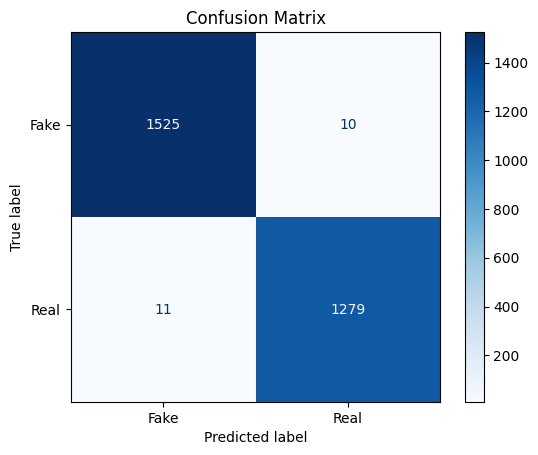

C:\Users\pasin\AppData\Local\Temp\ipykernel_28184\1117493396.py:70: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='navy')


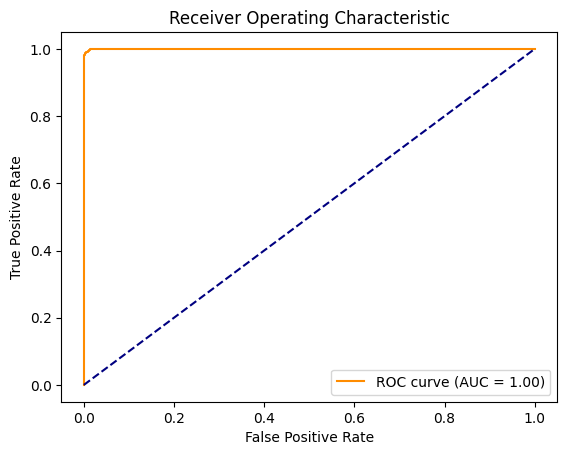

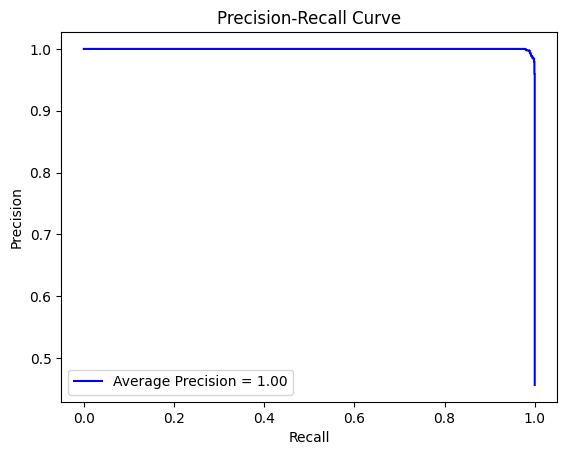

C:\Users\pasin\AppData\Local\Temp\ipykernel_28184\1117493396.py:92: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='navy', label='Perfectly Calibrated')


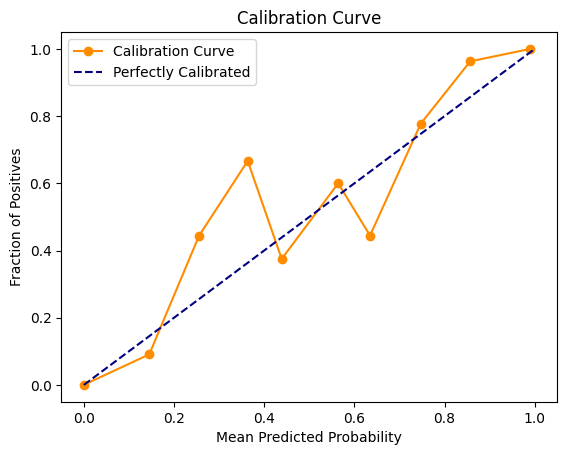

C:\Users\pasin\AppData\Local\Temp\ipykernel_28184\1117493396.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_true, palette='Set2')


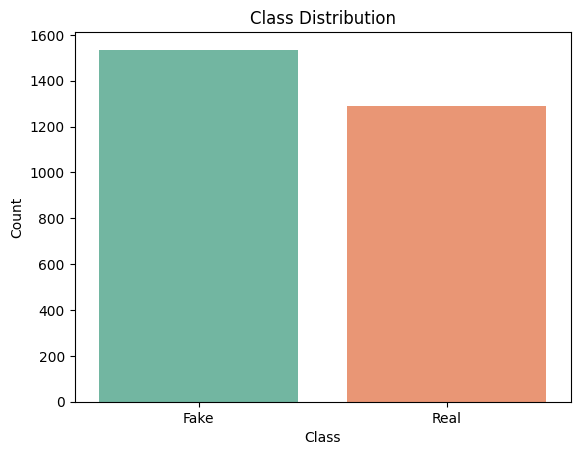

In [8]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import sklearn
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

import seaborn as sns

DATASET_PATH = r"E:\dataset\la-2019\audio-deepfake-detection-main\dataset"  # Training data path
TEST_DATASET_PATH = r"E:\dataset\la-2019\audio-deepfake-detection-main\testing"  # Testing data path
MODEL_PATH = "audio_classifier.h5" 
NUM_CLASSES = 2  # Fake or real
SAMPLE_RATE = 16000
DURATION = 5  # Duration of audio clips in seconds
N_MELS = 128
max_time_steps = 109


# Preprocess test data
X_test = []
true_labels = []
for file_name in os.listdir(TEST_DATASET_PATH):
    if file_name.endswith(".flac"):
        file_path = os.path.join(TEST_DATASET_PATH, file_name)
        audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
        mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

        if mel_spectrogram.shape[1] < max_time_steps:
            mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, max_time_steps - mel_spectrogram.shape[1])), mode='constant')
        else:
            mel_spectrogram = mel_spectrogram[:, :max_time_steps]

        X_test.append(mel_spectrogram)
        true_label = 0 if "fake" in file_name else 1
        true_labels.append(true_label)

X_test = np.array(X_test)
X_test = X_test[..., np.newaxis]
true_labels = np.array(true_labels)
y_true = true_labels

# Load model and predict
model = load_model(MODEL_PATH)
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_prob = y_pred[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
ConfusionMatrixDisplay(cm, display_labels=['Fake', 'Real']).plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', color='navy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
avg_precision = average_precision_score(y_true, y_pred_prob)
plt.figure()
plt.plot(recall, precision, label=f'Average Precision = {avg_precision:.2f}', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Calibration Curve
prob_true, prob_pred = calibration_curve(y_true, y_pred_prob, n_bins=10)
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', color='navy', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend(loc='upper left')
plt.show()

# Class Distribution
sns.countplot(x=y_true, palette='Set2')
plt.xticks(ticks=[0, 1], labels=['Fake', 'Real'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()




In [ ]:
y_true = np.array([1 if label == "bonafide" else 0 for label in true_labels.values()]) # y_true are the true labels for each file
y_true

In [7]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_true, y_pred_classes, target_names=['Fake', 'Real'])
print(report)

              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      1535
        Real       0.99      0.99      0.99      1290

    accuracy                           0.99      2825
   macro avg       0.99      0.99      0.99      2825
weighted avg       0.99      0.99      0.99      2825

